#### dependencies

In [39]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import time
import pickle
#from tqdm import tqdm as progress_bar
import cv2
from keras.datasets import cifar10

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from bornrule import BornClassifier
from Born_Functions import *

FE = Feature_Extraction()

#### feature extraction

In [40]:
#settings
#filename = 'pipe_results_imagenet'

extractor_dict = {
    'SIFT': cv2.SIFT_create(),
    #'ORB': cv2.ORB_create(edgeThreshold=10)
    }

supported_distance_metrics = {
    'euclidean': 'euclidean',
    #'cosine': 'cosine'
    }


k_values = [2500]

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(solver="saga", max_iter=1000),
    "MultinomialNB": MultinomialNB(),
    "KNeighbors": KNeighborsClassifier(),
    #"SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "BORN": BornClassifier()
    }




#### classes

pre preocessign

In [41]:
import cv2
from sklearn.model_selection import train_test_split

class Preprocessing:
    def __init__(self, extractor_dict):
        self.extractor_dict = extractor_dict

    def extract_descriptors(self, image, extractor):
        '''
        Extract the features of an image using a given extractor.
        Inputs:
            image: grayscale image of size (32, 32)
        Outputs:
            descriptors: np.array of size (extractor_len)
            kpoints: list of keypoints detected in the image
        '''
        # Extract the features using the given extractor
        kpoints, descriptors = extractor.detectAndCompute(image, None)
        
        if descriptors is None:
            return None, None
        
        return descriptors, kpoints

    def run_preprocess(self, X, y, extractor_name, test_size):
        '''
        Image preprocessing to create train and test sets, removing images without descriptors.
        Inputs:
            X: list of RGB or grayscale images
            y: labels associated with the images
            extractor_name: key name of the desired feature extractor
            test_size: fraction of the dataset to be used as test set
        Outputs:
            descriptors_train: list of training set descriptors
            descriptors_test: list of test set descriptors
            y_train: training set labels
            y_test: test set labels
        '''
        extractor = self.extractor_dict[extractor_name]
        filtered_X = []
        filtered_y = []
        missing_count = 0

        # Extract descriptors and filter out images with no descriptors
        for img, label in zip(X, y):
            descriptors, kpoints = self.extract_descriptors(img, extractor)
            if descriptors is not None:
                filtered_X.append(descriptors)
                filtered_y.append(label)
            else:
                missing_count += 1

        # Inform about the number of images removed
        print(f"Removed {missing_count} images due to missing descriptors.")

        # Split the remaining data into training and testing sets
        descriptors_train, descriptors_test, y_train, y_test = train_test_split(filtered_X, filtered_y, test_size=test_size, random_state=19)
        
        return descriptors_train, descriptors_test, y_train, y_test



configuration

In [42]:
class Configuration:
    def __init__(self, supported_distance_metrics, classifiers, k_values):
        self.supported_distance_metrics = supported_distance_metrics
        self.classifiers = classifiers
        self.k_values = k_values

    def build_visual_vocabulary(self, descriptors_list, k):
        features_reshaped = np.vstack([desc for desc in descriptors_list if desc is not None])
        minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100, n_init=3)
        minibatch_kmeans.fit(features_reshaped)
        visual_vocab = minibatch_kmeans.cluster_centers_
        return visual_vocab

    def build_histograms(self, descriptors_list, visual_vocab, distance_metric):
        k = visual_vocab.shape[0]
        histograms = np.zeros((len(descriptors_list), k))
        for i, descriptors in enumerate(descriptors_list):
            if descriptors is None:
                continue
            distances = cdist(descriptors, visual_vocab, metric=distance_metric)
            closest_clusters = np.argmin(distances, axis=1)
            for cluster_idx in closest_clusters:
                histograms[i][cluster_idx] += 1
        return histograms

    def run_configuration(self, descriptors_train, descriptors_test, y_train, y_test, k, distance_metric_, classifier_):
        visual_vocab = self.build_visual_vocabulary(descriptors_train, k)
        distance_metric = self.supported_distance_metrics[distance_metric_]
        histograms_train = self.build_histograms(descriptors_train, visual_vocab, distance_metric)
        histograms_test = self.build_histograms(descriptors_test, visual_vocab, distance_metric)
        
        classifier = self.classifiers[classifier_]
        classifier.fit(histograms_train, y_train)
        predictions = classifier.predict(histograms_test)
        results = {'y_obs': y_test, 'y_pred': predictions}

        return results


#### data

In [43]:
# ##Imagenet
# df = pd.read_pickle("imagenet.pkl")
# df.columns = ["images", "labels"]

# # resize images
# image_size = (256, 256)

# # Ridimensionare tutte le immagini e convertirle in un array
# X_img = np.array([cv2.resize(img, image_size, interpolation=cv2.INTER_AREA) for img in df["images"]])
# y_img = df["labels"].to_numpy()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0).flatten()

X =  np.array([FE.convert_to_grayscale(img) for img in X])


#descriptors

#### Conteggio descriptors

In [ ]:
# prepr = Preprocessing(extractor_dict)
# ext = extractor_dict['SIFT']
# count_img, count_cif = [], []
# cn, cf = 0,0
# for img in X_img:
#     descriptors, kpoints = prepr.extract_descriptors(img, ext)
#     if descriptors is not None:
#         count_img.append(descriptors)
#     else: cn = cn+1


# for img in X_cifar:
#     descriptors, kpoints = prepr.extract_descriptors(img, ext)
#     if descriptors is not None:
#         count_cif.append(descriptors)
#     else: cf = cf+1


# co = 0
# count_orb = []
# for img in X_cifar:
#     descriptors, kpoints = prepr.extract_descriptors(img, extractor_dict['ORB'])
#     if descriptors is not None:
#         count_orb.append(descriptors)
#     else: co = co+1



# cf, cn, co
# len_cif = [len(c) for c in count_cif]
# len_img = [len(c) for c in count_img]
# len_orb = [len(c) for c in count_orb]
# np.sum(len_cif), np.sum(len_img), np.sum(len_orb)

#### split datasets.

In [44]:
def extract_balanced_subsets(X, y, sizes, num_versions=5):
    num_classes = 10
    subsets = {size: [] for size in sizes}
    
    for size in sizes:
        for _ in range(num_versions):
            samples_per_class = size // num_classes
            x_subset = []
            y_subset = []
            for class_id in range(num_classes):
                idx = np.where(y == class_id)[0]
                chosen_idx = np.random.choice(idx, samples_per_class, replace=True)
                x_subset.append(X[chosen_idx])
                y_subset.append(y[chosen_idx])
            x_subset = np.concatenate(x_subset, axis=0)
            y_subset = np.concatenate(y_subset, axis=0)
            subsets[size].append((x_subset, y_subset))
    
    return subsets


In [45]:
extractor_dict = {
    'SIFT': cv2.SIFT_create()
    }

supported_distance_metrics = {
    'euclidean': 'euclidean'
    }

classifiers = {
    "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
    "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
    "BORN(1,0,0)": BornClassifier(1,0,0),
    "BORN(1,0,1)": BornClassifier(1,0,1),
    "MultinomialNB": MultinomialNB()
    }

In [46]:
extractor_name = 'SIFT'  
test_size = 0.2

prep = Preprocessing(extractor_dict)
config = Configuration(supported_distance_metrics, classifiers, k_values)

In [47]:
# Example of usage
#xt, xp, yt, yp = prep.run_preprocess(X, y, extractor_name, test_size)

def collect_results(xt, xp, yt, yp, classifier):
    start_time = time.time()
    result = config.run_configuration(xt, xp, yt, yp, 1000, 'euclidean', classifier)
    end_time = time.time()
    f1 = f1_score(result['y_obs'], result['y_pred'], average='weighted')
    comp_time = end_time - start_time

    return f1, comp_time


def run_preprocess_and_collect_results(X, y, extractor_name, test_size, classifier):
    xt, xp, yt, yp = prep.run_preprocess(X, y, extractor_name, test_size)
    f1, comp_time = collect_results(xt, xp, yt, yp, classifier)
    return f1, comp_time

In [48]:
results_df = pd.DataFrame(columns=['Subset Size', 'Average F1', 'Average Computation Time'])

# Subset sizes
sizes = [100,1000,5000]
subsets = extract_balanced_subsets(X, y, sizes)
extractor_name = "SIFT"  # Replace with your actual extractor name
test_size = 0.2  # Example test size

df_dict = {}
# Process each subset size

for size in sizes:
    results_df = pd.DataFrame()
    f1_scores = []
    computation_times = []

    for classifier in classifiers:
        for subset in subsets[size]:
            X_subset, y_subset = subset
            f1, comp_time = run_preprocess_and_collect_results(X_subset, y_subset, extractor_name, test_size, classifier)
            f1_scores.append(f1)
            computation_times.append(comp_time)

    # Calculate averages
    avg_f1 = np.mean(f1_scores)
    avg_comp_time = np.mean(computation_times)
    
    # Create a temporary DataFrame to append
    temp_df = pd.DataFrame({
        'Subset Size': [size],
        'Average F1': [avg_f1],
        'Average Computation Time': [avg_comp_time]
    })
    
    # Append results to the main DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

df_dict[classifier] = results_df
    

# Display the DataFrame
print(results_df)


Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 images due to missing descriptors.
Removed 0 

In [ ]:
len(subsets[100])

5

In [ ]:
1/0

#### graph

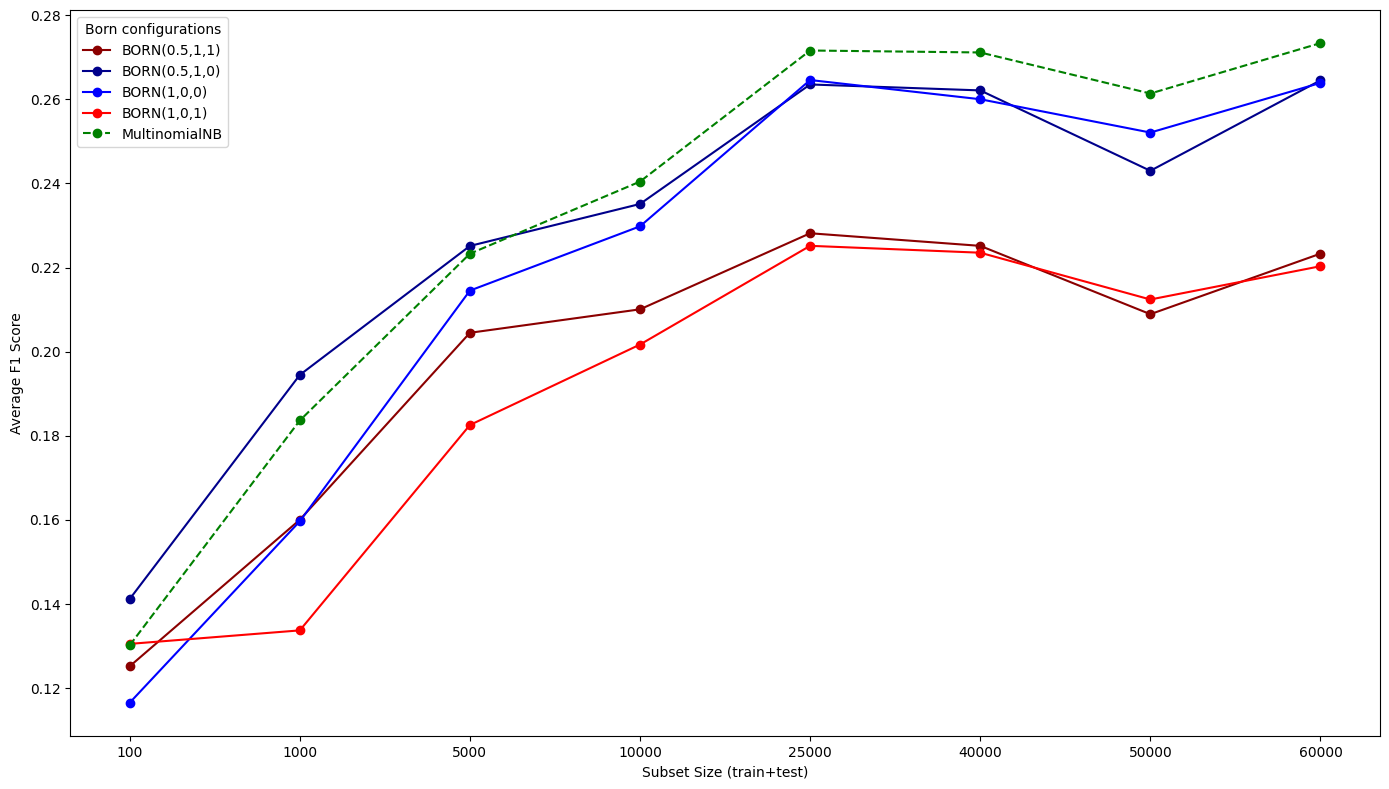

In [29]:
import matplotlib.pyplot as plt

# # Dati forniti dalla tabella LaTeX
# x_values = ['100', '1000', '5000', '10000', '25000', '40000', '50000', '60000']
# y_values = [
#     [0.177, 0.157, 0.166, 0.184],
#     [0.162, 0.183, 0.142, 0.136],
#     [0.237, 0.255, 0.248, 0.214],
#     [0.235, 0.250, 0.245, 0.225],
#     [0.236, 0.266, 0.267, 0.236],
#     [0.225, 0.258, 0.256, 0.221],
#     [0.220, 0.261, 0.260, 0.219],
#     [0.244, 0.273, 0.275, 0.242]
# ]

# Nomi dei BORN classifier
labels = ['BORN(0.5,1,1)', 'BORN(0.5,1,0)', 'BORN(1,0,0)', 'BORN(1,0,1)', 'MultinomialNB']


x_values = ['100', '1000', '5000', '10000', '25000', '40000', '50000', '60000']

y_values = [
    [0.125143, 0.160002, 0.204474, 0.210055, 0.228149, 0.225152, 0.208900, 0.2233],
    [0.141143, 0.194453, 0.225133, 0.235117, 0.263544, 0.262130, 0.243008, 0.264523],
    [0.116476, 0.159637, 0.214512, 0.229801, 0.264597, 0.260032, 0.252105,0.263912],
    [0.130476, 0.133687, 0.182540, 0.201684, 0.225161, 0.223523, 0.212395,0.220310],
    [0.130143, 0.183612, 0.223290, 0.240440, 0.271621, 0.271155, 0.261386, 0.273380]
]

labels = ['BORN(0.5,1,1)', 'BORN(0.5,1,0)', 'BORN(1,0,0)', 'BORN(1,0,1)', 'MultinomialNB']


# Trasponi y_values per ottenere una lista di valori per ciascuna linea
y_values_transposed = list(map(list, zip(*y_values)))

# Crea il grafico a linee
fig, ax = plt.subplots(figsize=(14, 8))

# Definisci i colori per ciascuna linea
colors = ['darkred', 'darkblue', 'blue', 'red', 'green']

# Traccia ciascuna linea
for i, (y, color) in enumerate(zip(y_values, colors)):
    if labels[i] == 'MultinomialNB':
        ax.plot(x_values, y, marker='o', label=labels[i], linestyle='--', color=color)
    else:
        ax.plot(x_values, y, marker='o', label=labels[i], color=color)

# Aggiungi etichette e titolo
plt.xlabel('Subset Size (train+test)')
plt.ylabel('Average F1 Score')
plt.legend(title='Born configurations')

plt.tight_layout()
plt.show()
